# Лекция 3: Программная платформа Hadoop. Распределенная файловая система HDFS

- экосистема Hadoop занимает 70% рынка

<u>Плюсы:</u>
- она `opensorce`
- надежная
- поддреживает разные интеграции

**Основные темы:**

- Hadoop как система распределенной обработки данных
- Назначение и отличительные особенности HDFS
- Основные компоненты HDFS
- Операции чтение/запись в HDFS
- HDFS HA
- Hadoop 3.x – HDFS

***Распредделенная система Hadoop:***

1) Разработчики Hadoop нацелились на 3 вещи:
- большие объем
- различные вычисления
- большие данные с точки зрения структуры

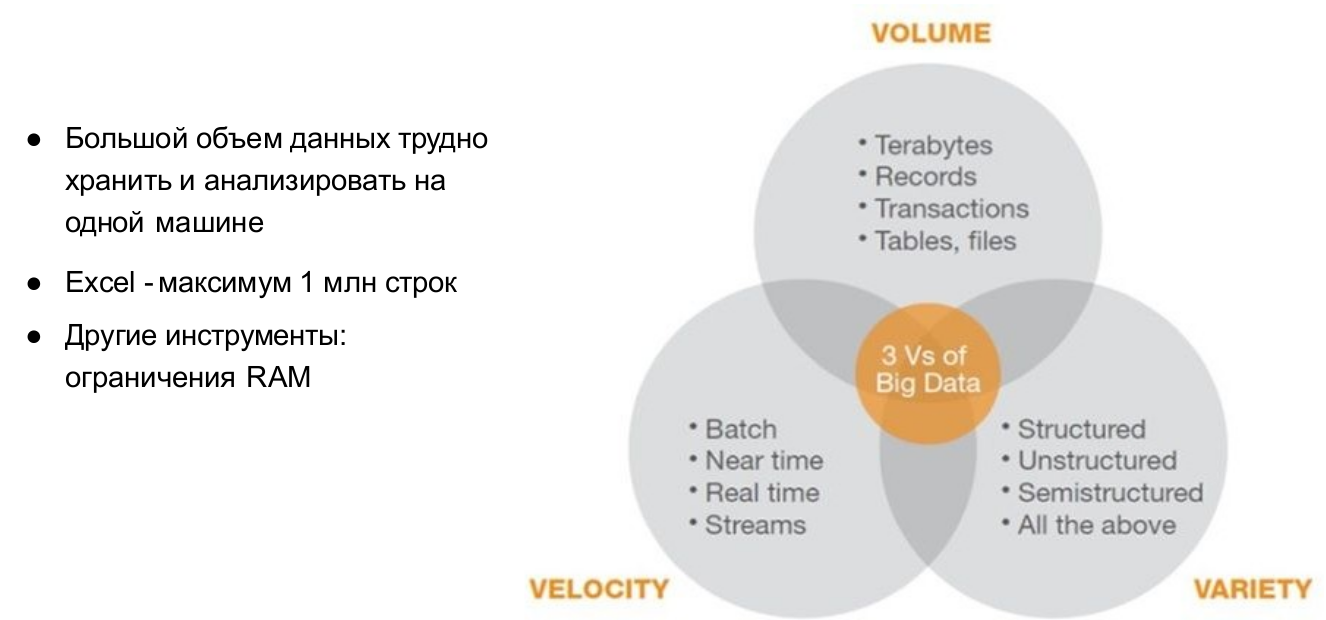

2) Обойти борьбу за ресурсы:

![image copy.png](<attachment:image copy.png>)

- `Конкурентность` - ощущается, так как-будто все параллельно выполняется. (Но на самом деле это не так...)
- `Параллелизм` - истинное разделение ресурсов. Не всегда распараллеливание хорошо.

Есть разные ситуации, когда-то выигрывает конкурентность, а когда-то параллелизм.

3) **Принципы**:

- Задачи должны быть разделены на независимые друг от друга подзадачи (≈ функциональное программирование здесь лучше, т.к. здесь методы быстрее и понятнее работают в этой парадигме(в отличие от ООП))
- Один из компьютеров координирует работу вычислительных узлов
- Hadoop - один из примеров системы распределенных вычислений

![image copy 2.png](<attachment:image copy 2.png>)

<u>Слои:</u>
- HDFS - слой хранения данных
- YARN - слой управления данными
- Все остальное слой обработки данных

4)**Особенности Hadoop**

- Масштабируемость - можно много worker-ов добавлять
- Отказаустойчивость
- Доступность - opensorce инструмент ...
- Вычисления приближены к данным - на 1 занятии говорили
- Высокая пропускная способность I/O
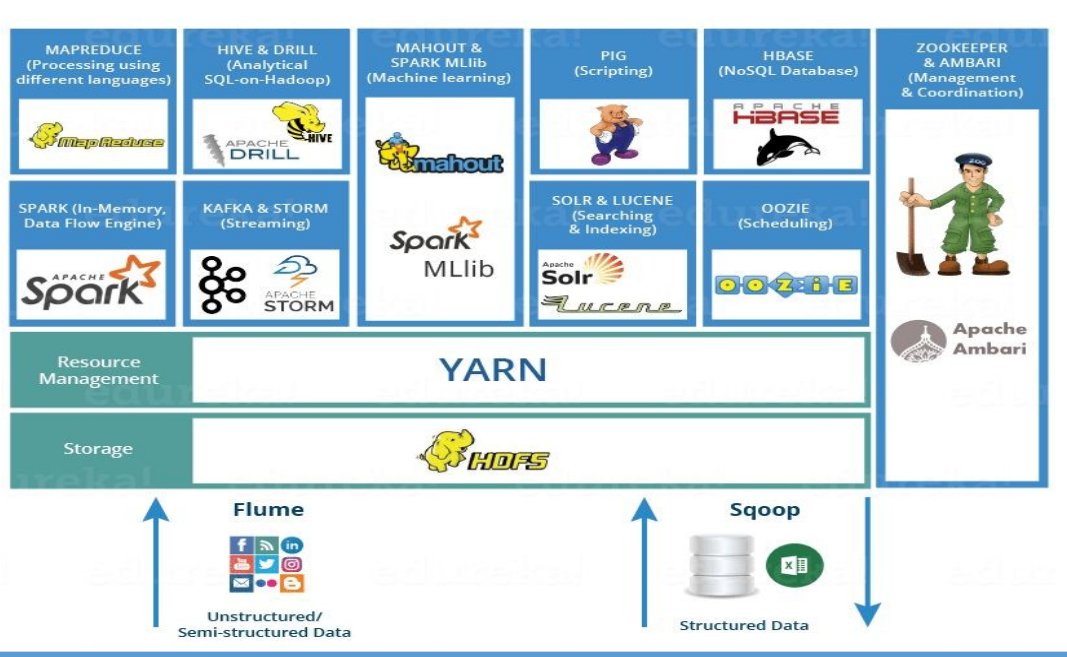
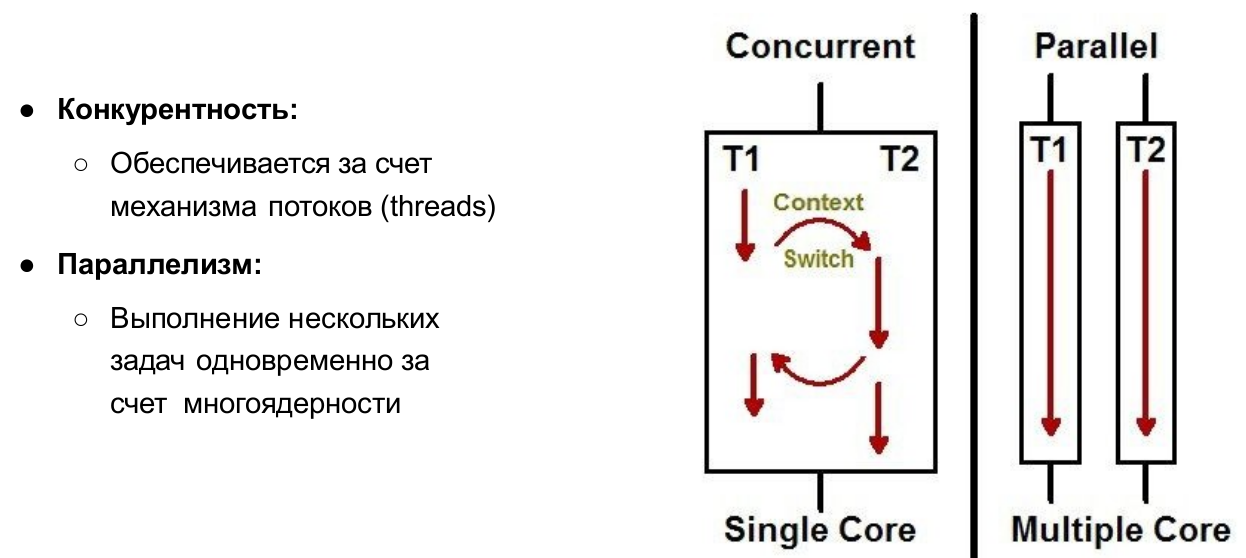

# HDFS [статья от skillbox](https://skillbox.ru/media/code/hdfs-kak-khranyatsya-bolshie-dannye/)

![image copy 3.png](<attachment:image copy 3.png>)

<u>Ключевые слова:</u>
- распределенная система
- серверами общего назначения

**Про стратегию write-once / read-many:**
- стратегия write-one / read-many - это считай поисковик GOOGLE
- это такая система баланса... 
- В MLOPS стратегия write-many / read-many - в MLOPS говрят о том, что у нас есть много озер данных и мы туда записываем данные и не обязательно он у нас находится...

![image copy 4.png](<attachment:image copy 4.png>)
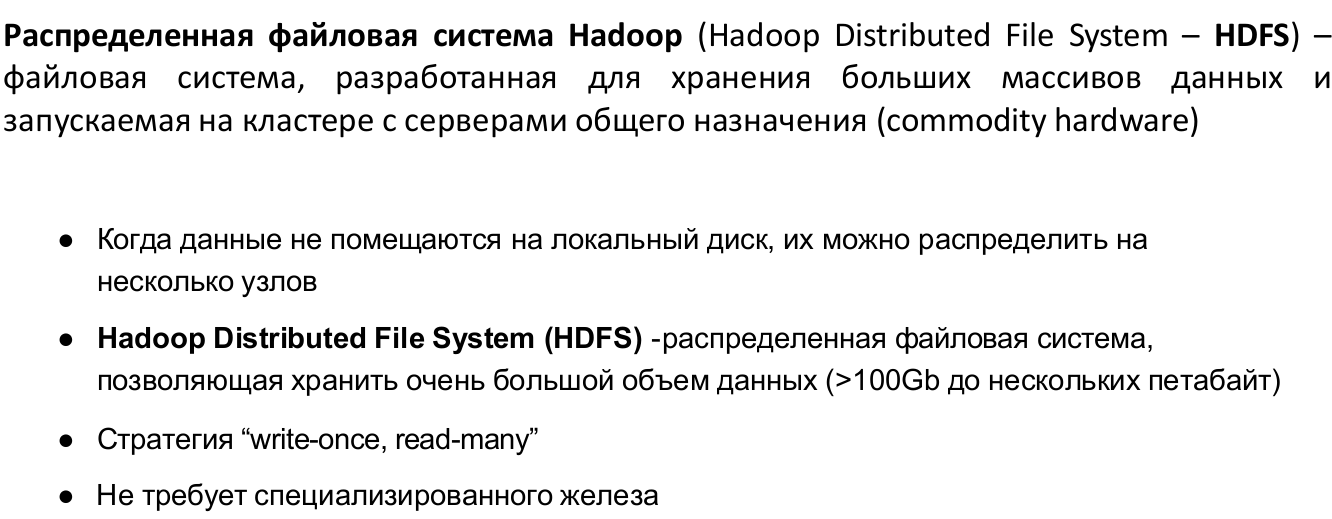
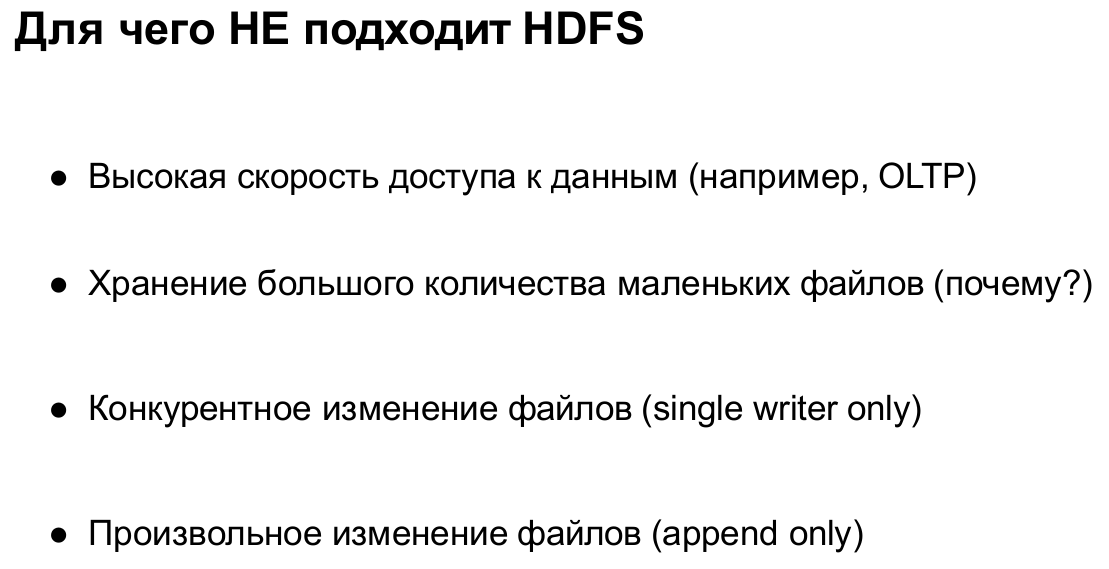

## **Компоненты HDFS**

![image copy 5.png](<attachment:image copy 5.png>)

![image copy 6.png](<attachment:image copy 6.png>) 

- `Стойка` - это видимо, как класстер в статье SKILLBOX, просто много серверов объединеных в одну группу (сервера могут быть разделены физически или логически)
- `Узел` - здесь понимается, как раз таки разделение на сервера, но они могут быть просто разделены гипервизором
- `Datanode` - демон, который находится в каждом узле
- `Блоки` - часть файла, который хранится в Datanode. Они также реплецируются максимально удаленны друг от друга по узлам
- `NameNode` - master/главный узел, который управляет всем этим
- `Клиент HDFS` - связывает NameNode и клиентов по API
- `Гипервизор (англ. Hypervisor)` — это программное обеспечение, которое позволяет одновременно запускать несколько операционных систем (ОС) на одном физическом устройстве 

Каждый блок реплцируется...

- Datanode - контейнер
- Все это управляется МАСТЕРОМ

![image copy 7.png](<attachment:image copy 7.png>)

- Файл делиться на блоки размером (сам выбираешь 64/128/256 МБ) В основном 128
- Количество реплик можно менять 0/1 и т.д. (Надо балансировать) По умолчанию их 3

**Что будет если блоки слишком маленькие или большие?**
- Если блоки слишком маленькие, то под них все-равно будет выделено 64 или 128 МБ (в зависимоти от размера блока), просто будет забита мусорными данными
- Если очень маленький объем данных, то будет выделено 64 МБ... (оставшаяся часть будет забита мусорными данными)

`Namenode` служба, которая управляет пространством файловой системы и поддерживает
- дерево файловой системы
- метаданные о всех файлах и папках
- списки (информация где блоки храняться): файл -> блоки -> datanodes(то где эти блоки будут храниться)

`NameNode` состоит из FSimage и EditLog, про это лучше почитать в статье

![image copy 8.png](<attachment:image copy 8.png>)

`DataNode` просто хранит информацию и записывают и читают данные
- heartbeats - сообщение о своей работоспособности
- Datanodes меньше чем клиентов, т.к. выгоднее один Datanode нагружать по полной нежелее создавать новый...
- Каждый Datanode регестрируется в Namenode во время запуска системы (вплоть до IP)

![image copy 9.png](<attachment:image copy 9.png>)

- Это сообщения от DataNode-а к NameNode-у

Параметры времени настраиваемый для Heartbeats и не нужно ставить время измеряемое в часах...
`Block report` - это информация для обновления информации...

## Heartbeats (Пульс)
Что это? Это очень маленькие и частые сигналы, которые каждый DataNode (рабочий) посылает NameNode (диспетчеру). Название "heartbeat" (сердцебиение) отлично отражает суть — это сигнал "я жив и здоров".

Как часто? Как и указано на слайде, по умолчанию это происходит каждые 3 секунды.

Какую информацию передает?

Статус: Главное — сам факт прихода сигнала подтверждает, что DataNode работает.

Нагрузка и ресурсы: Вместе с "пульсом" узел данных сообщает краткую сводку о себе:

Доступный объем дискового пространства: "У меня осталось X гигабайт свободного места". Это помогает NameNode принимать решения, куда отправлять новые данные.

Сколько используется для хранения: "Мои диски заняты на Y%".

Количество передаваемых данных в текущий момент: "Сейчас я активно принимаю/отдаю Z блоков". Это помогает NameNode балансировать нагрузку.

Что будет, если "пульс" пропадет?
Если NameNode не получает heartbeat от какого-то DataNode в течение определенного времени (по умолчанию 10 минут), он считает этот узел "мертвым" или недоступным. После этого NameNode запускает процесс репликации: он находит блоки, которые хранились на "погибшем" узле, и создает их копии на других, работающих DataNode, чтобы сохранить надежность хранения данных.

## Block Report (Отчет о блоках)
Что это? Это полный список всех блоков данных, которые хранятся на конкретном DataNode. Если Heartbeat — это короткое "я в порядке", то Block Report — это детальная инвентаризация: "Вот полный перечень всех товаров (блоков), которые лежат у меня на полках".

Как часто? Этот процесс гораздо более ресурсоемкий, чем отправка "пульса", поэтому он происходит значительно реже. На слайде указано "часы - 1", что является правдой. По умолчанию полный отчет о блоках отправляется каждые 6 часов.

Какую информацию содержит?

Id блока (Block ID): Уникальный идентификатор каждого блока.

Метка поколения (Generation Stamp): Это служебная информация, которая помогает отслеживать версии блоков, например, при операциях восстановления.

Размер каждого блока (Block Size): Длина блока в байтах.

Зачем он нужен?
Этот отчет — главный источник правды для NameNode о том, где физически расположены все части всех файлов. NameNode использует эту информацию для построения и поддержания актуальной карты расположения блоков (BlockMap).[11] Эта карта критически важна: когда клиент хочет прочитать файл, NameNode заглядывает в нее и говорит, к каким DataNode и за какими блоками нужно обратиться.
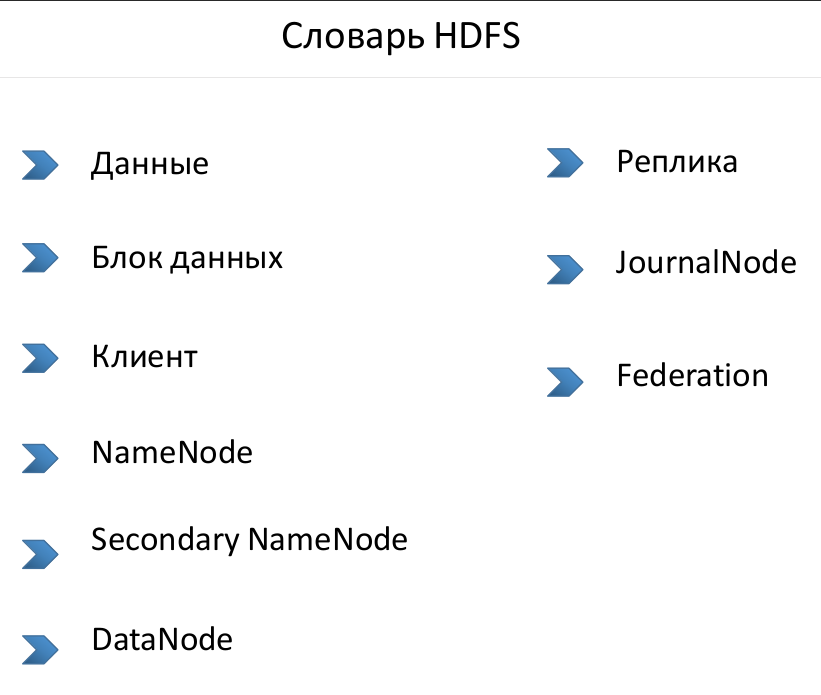
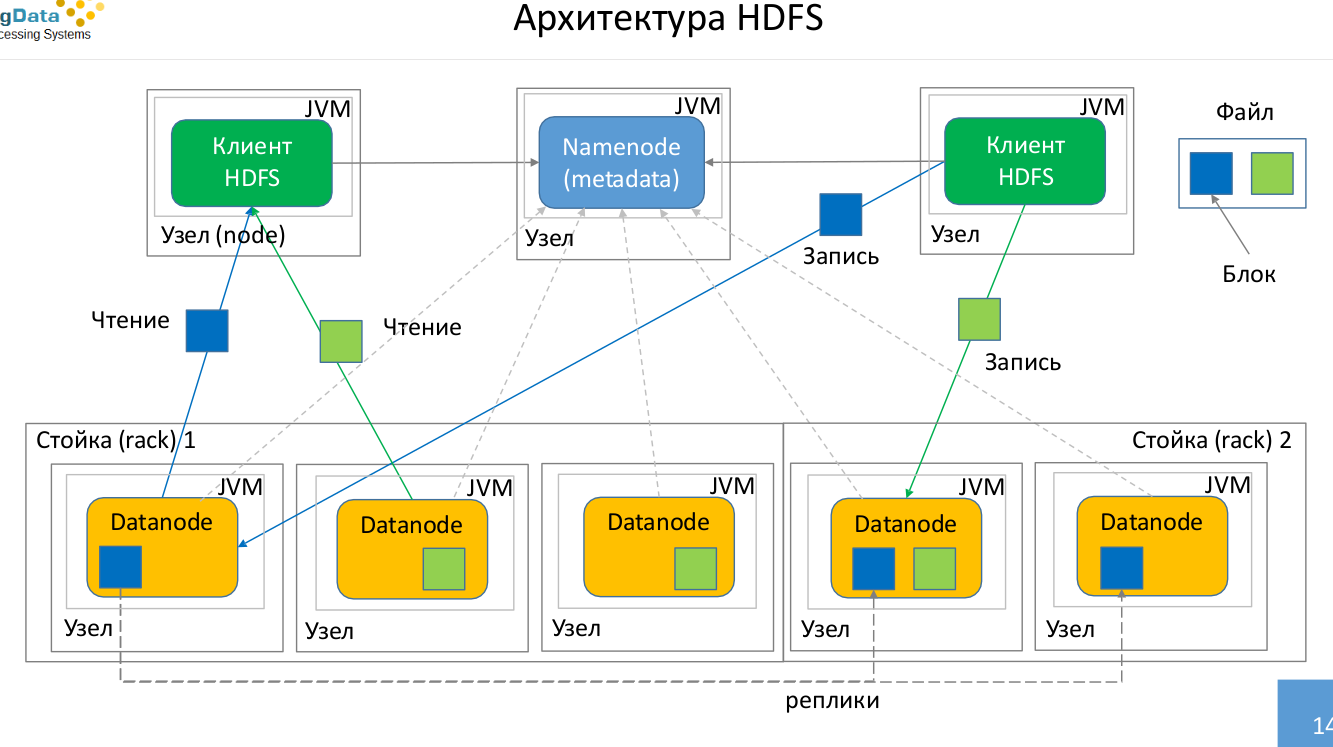
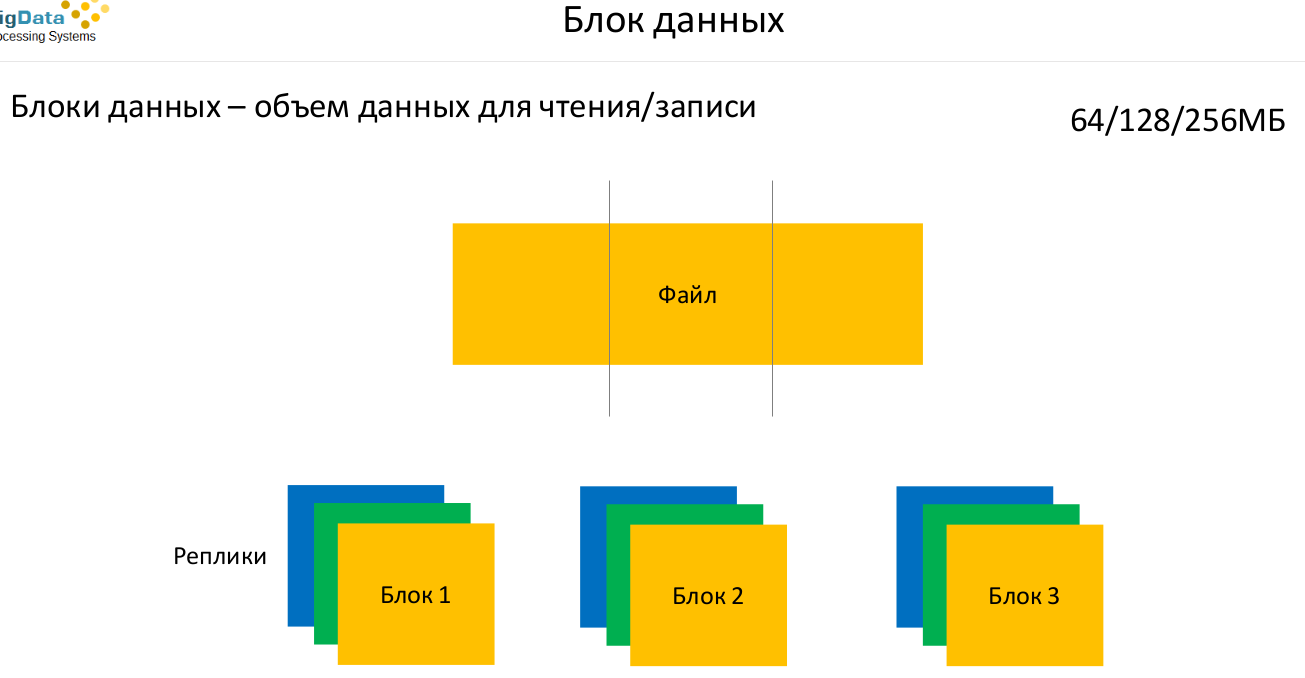
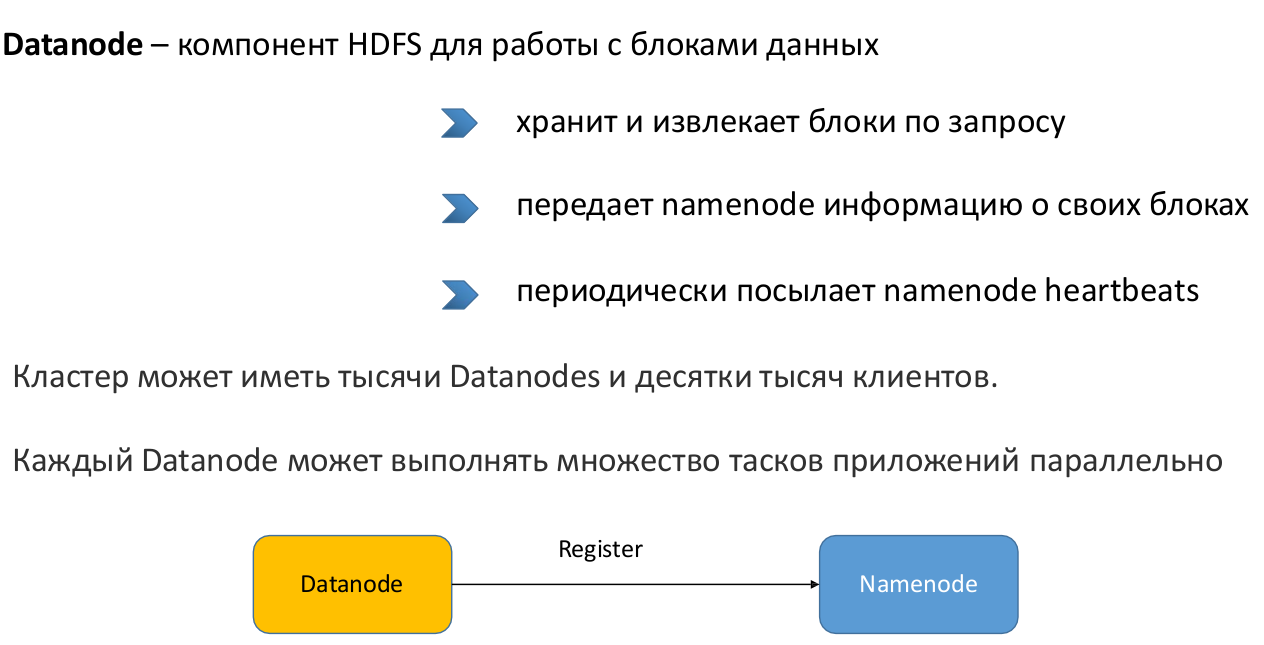
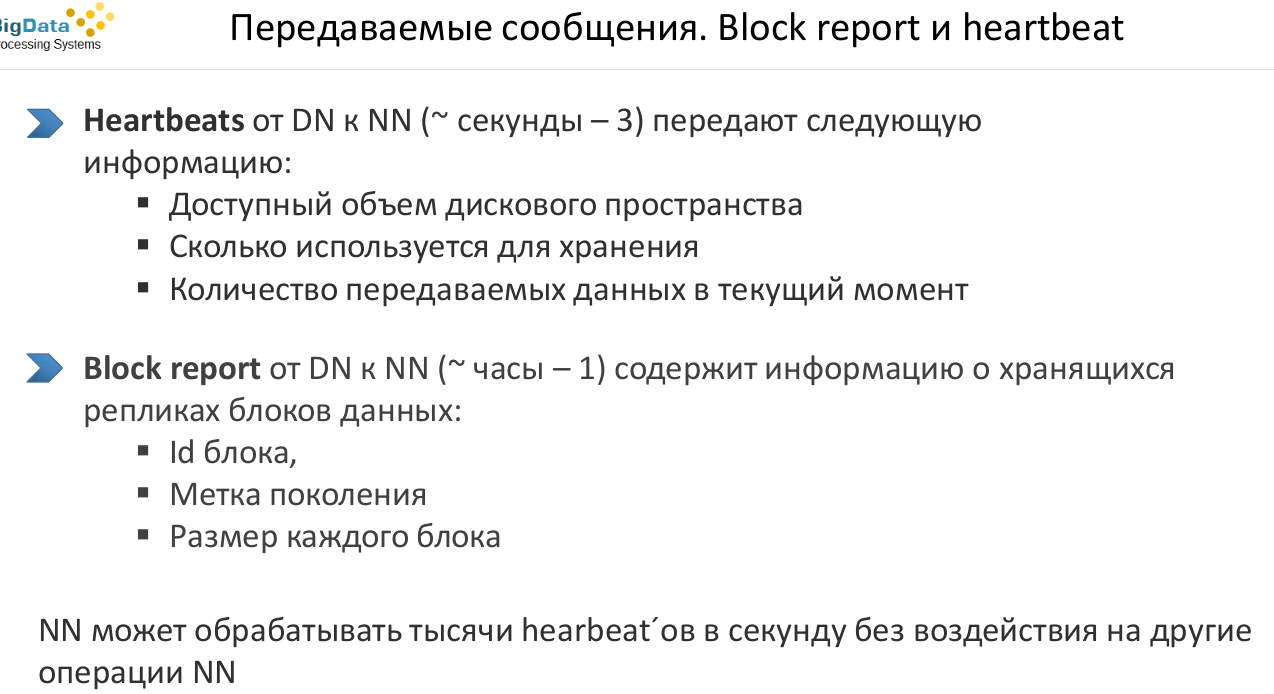

![image copy 10.png](<attachment:image copy 10.png>)

Namenode кидает ответ Datanode...

![image copy 11.png](<attachment:image copy 11.png>)

![image copy 21-2.png](<attachment:image copy 21-2.png>)
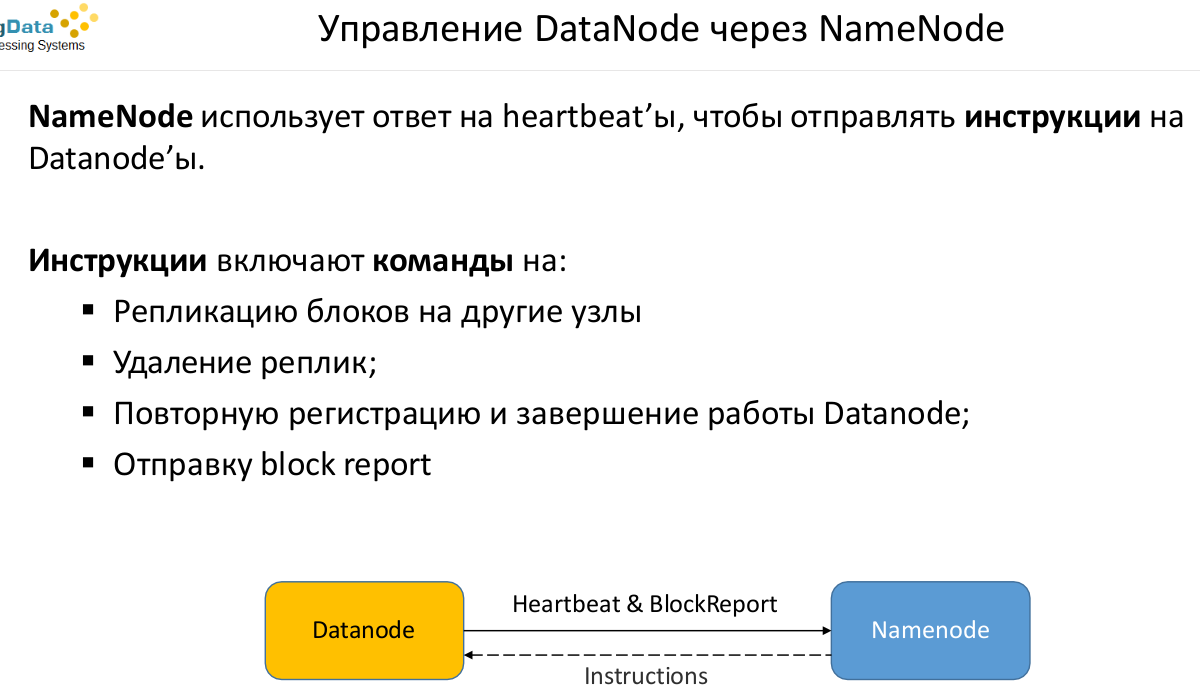
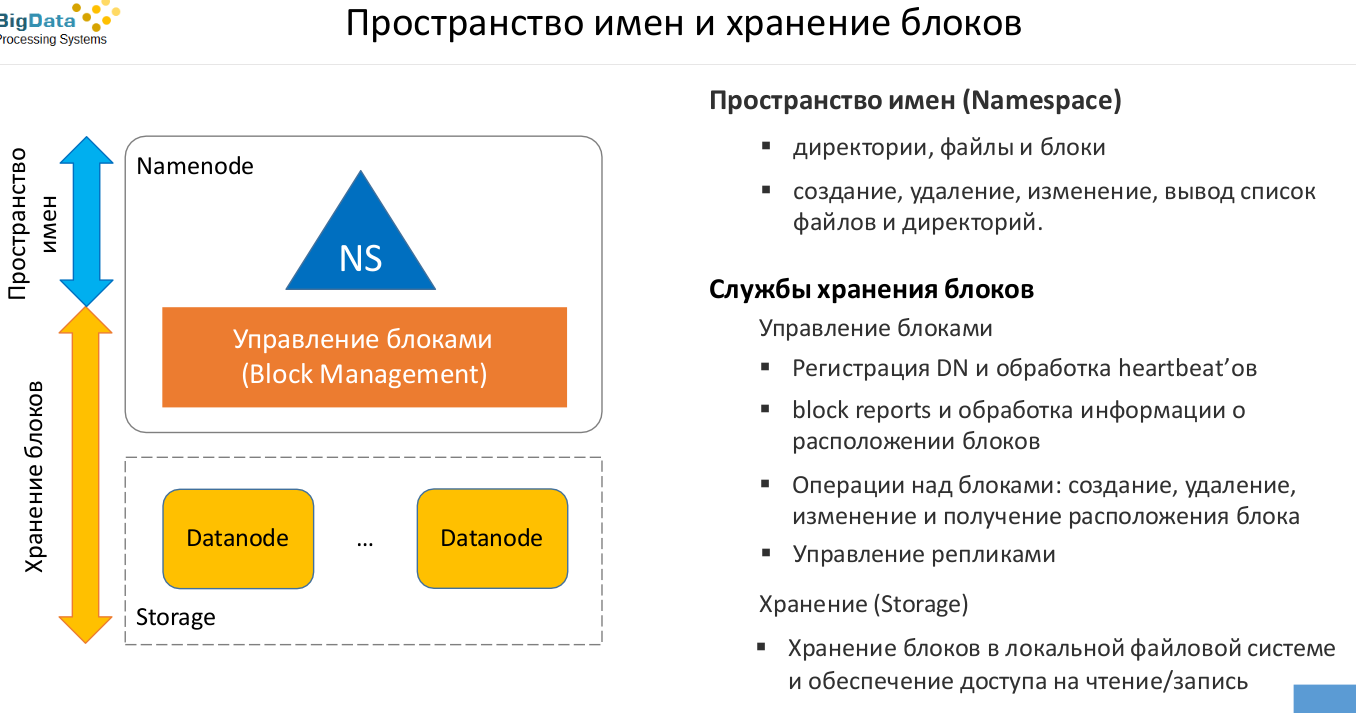
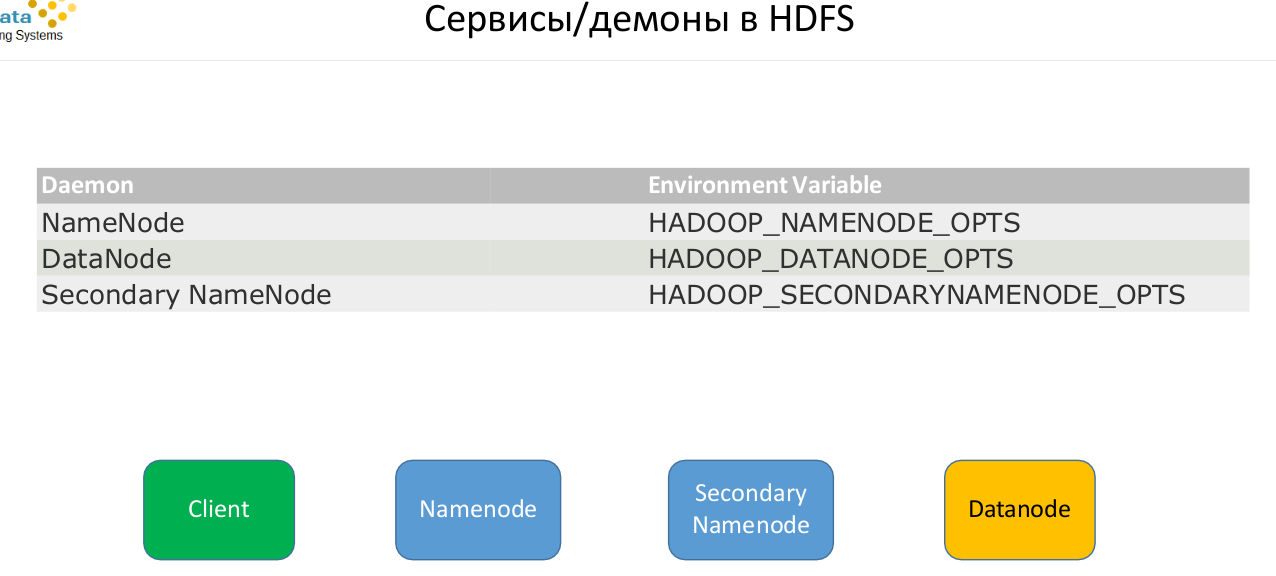
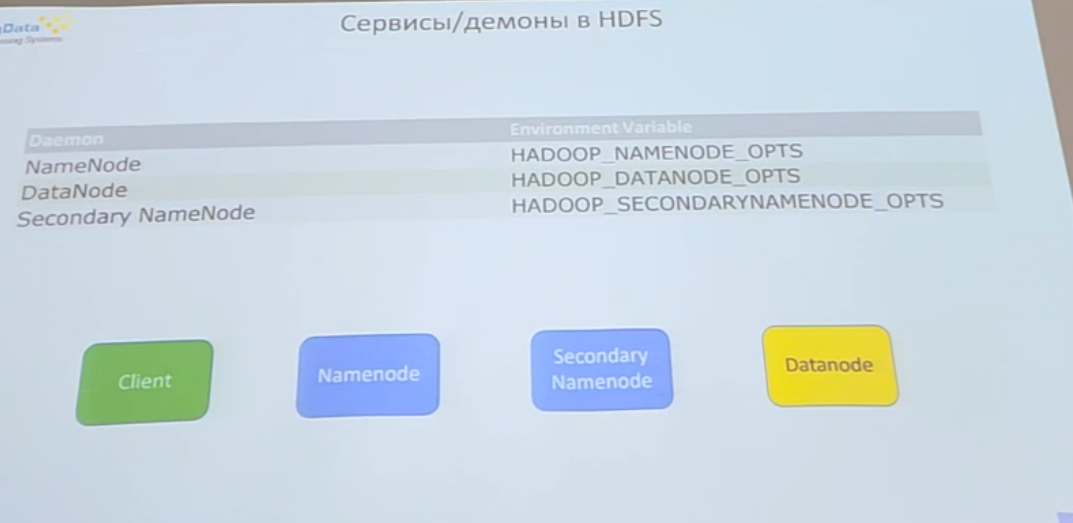

# ОСНОВНЫЕ КОМАНДЫ В HDFS

- очень похож на Linux
- [ДОКУМЕНТАЦИЯ1](https://hadoop.apache.org/docs/r2.7.2/hadoop-project-dist/hadoop-common/FileSystemShell.html)
- [ДОКУМЕНТАЦИЯ2](https://hadoop.apache.org/docs/r2.7.0/hadoop-project-dist/hadoop-hdfs/HDFSCommands.html)

![image copy 12.png](<attachment:image copy 12.png>)

**Операции чтения/записи данных**
- hadoop НЕ любит информацию записи данных, а чтения данных любит

![image copy 13.png](<attachment:image copy 13.png>)

*Алгоритм чтения данных:*
1) Клиент под управлением ВИРТУАЛЬНОЙ МАШИНЫ обращается к NameNode-у он обращается для того, чтобы получить информацию из каких блоков состаит тот файл, который мы хотим найти и где эти блоки можно найти
- к NameNode-у черзе DistributedFileSystem функцию
- к DataNode-у через FSDataInputStream функцию
2) Клиенту теперь возвращается вся необходимая информаци
3) Клиент обращается к DataNode-ам по их IP-шникам и читает нужные блоки данных

![image copy 14.png](<attachment:image copy 14.png>)

*Алгоритм записи данных:*
1) Когда у нас есть файл, который мы хотим записать, нам нужно NameNode-у сказать, что у нас есть этот файл (create())
2) NameNode на основе тех данных, которые у него есть от hearbet-ов и block repor-то (какие узлы живы, какая у них пропускная способность и т.д), делит файл на блоки и реплецирует и начинает записывать на DataNode-ы, но делает он это через клиента, т.к. его фукнция управлять, а не скачивать эти файлы... Следовательно он просто дает информацию эту клиенту на какие DataNode-ы какие блоки стоит отправить
3) Как правило клиент общается только с одним DataNode-ом, через который переадется вся информация другим DataNode-ам (это узкое горлышко бутылки)
4) Каждый DataNode отправялет сообщение о том, что он получил этот пакет
5) Также NameNode обновляет информацию в EditLog о том, что произошло скачивание файла + `DataNode-ы` отправят block repoted потом (тут то NameNode может налажать и дать клиенту читающему не доставерную информацию, т.к. ack пакеты же имеют определеннную задержку... Поэтому стратегия один пишет много читаю в выигрышной позиции...)

*Как определяется растояние где реплики должны лежать?*
- В настройках есть параметр, который за это отвечает... Чем больше этот параметр, тем дальше будет находится реплика от клиента( d=0 может быть, и тогда этот block запишется там же, где клиент)

![image copy 22.png](<attachment:image copy 22.png>)

---
- Если Datanode-потеряется, то ничего страшного
- Если потеряется Namenode - то потеряется все...
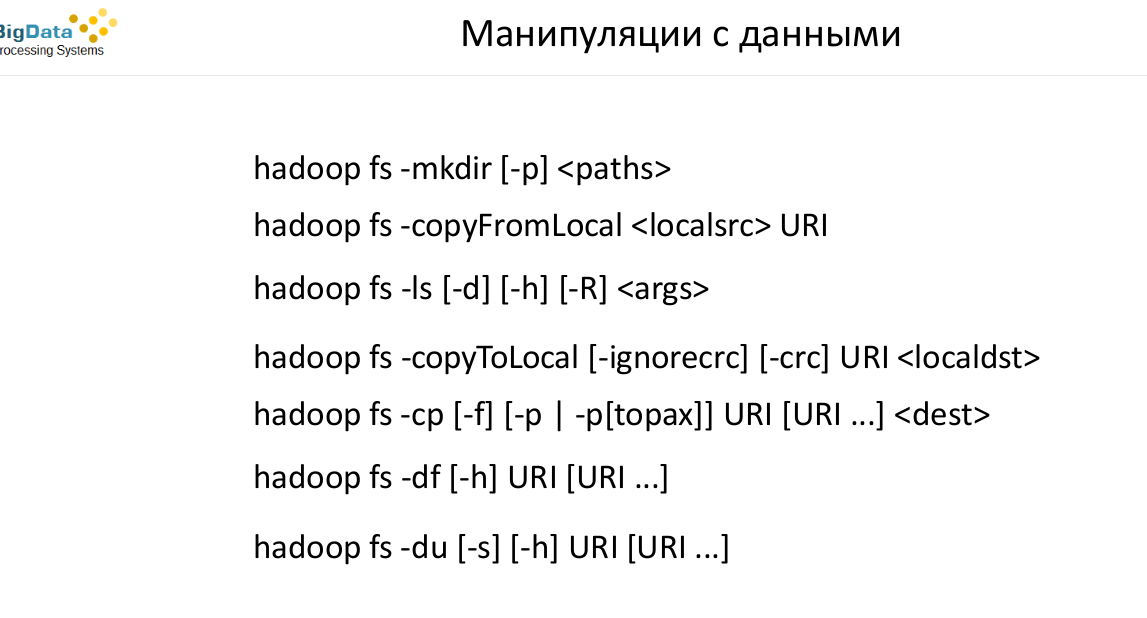
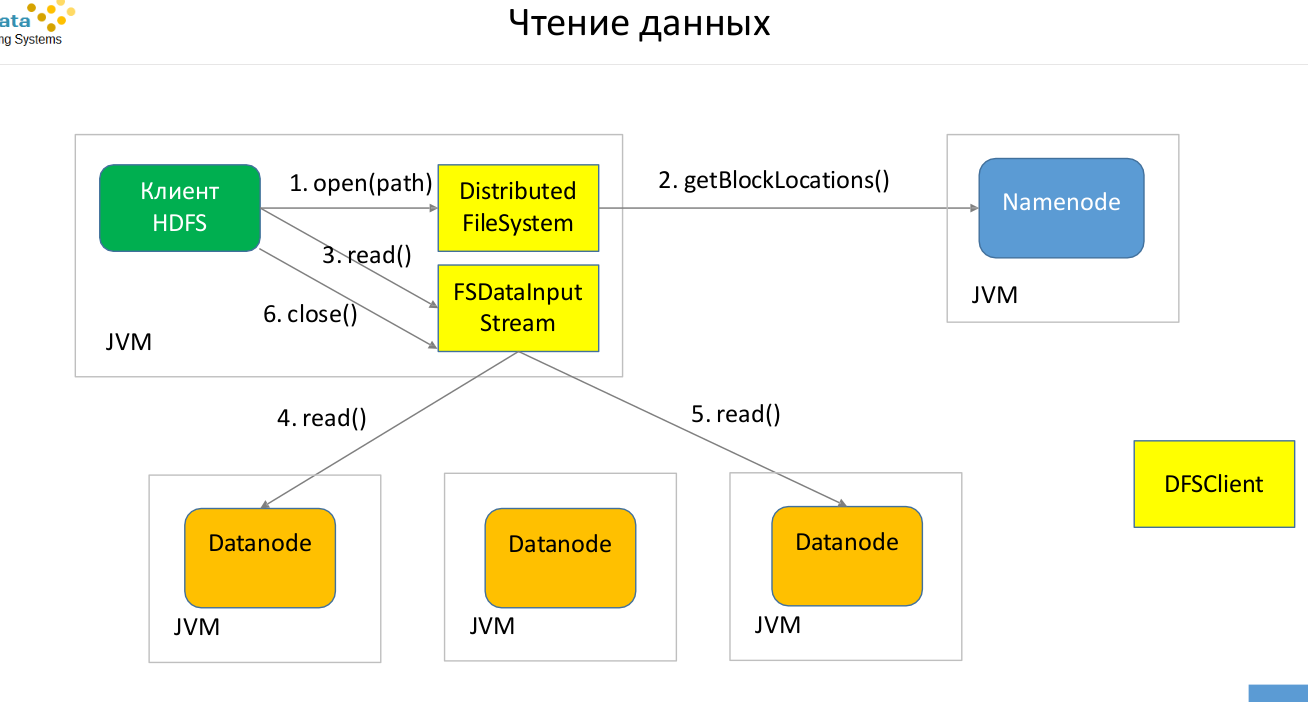
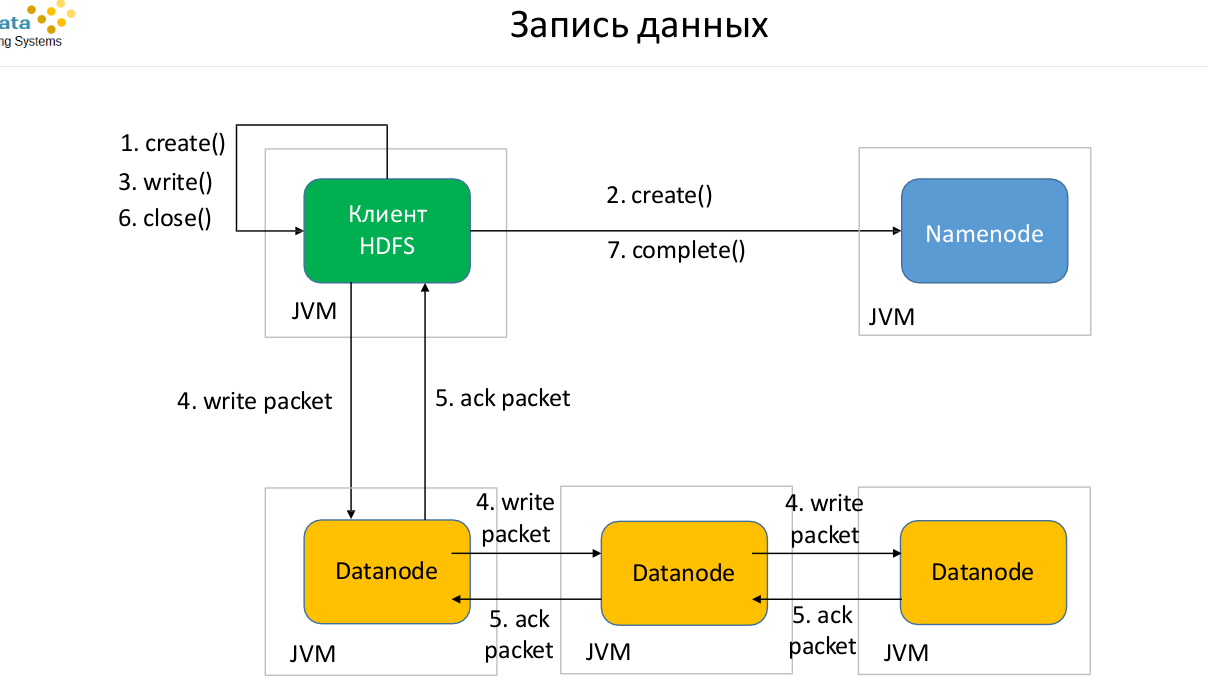
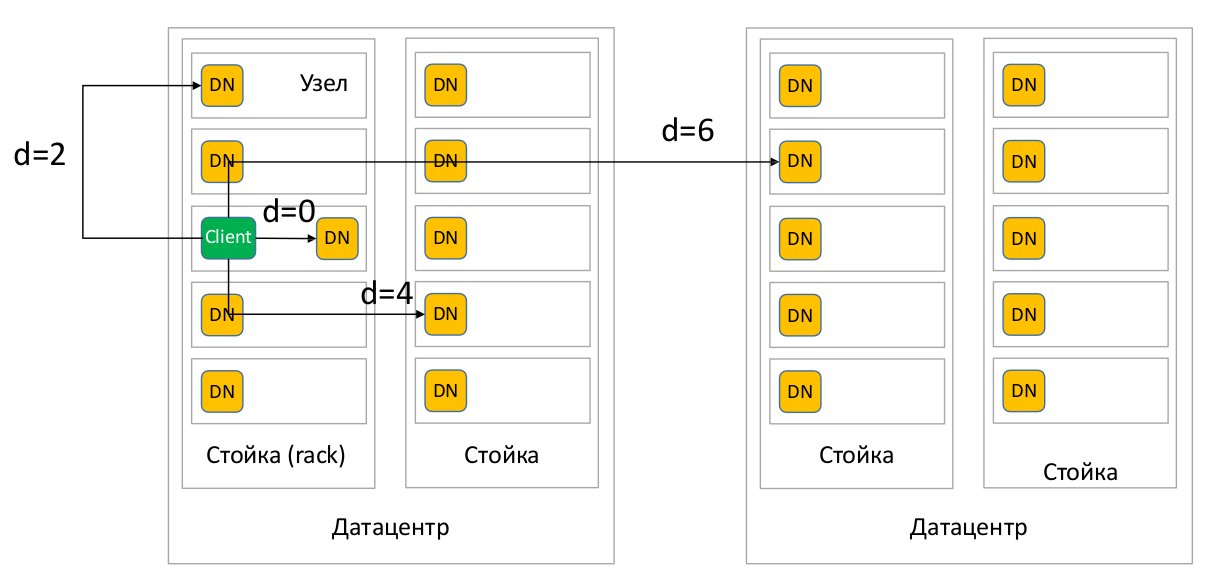

Дополнительные возможности:

1) Secondary NameNode - механизм из коробки, в статье от SKILLBOX рассказывается

Namenode хранит образ всего пространства имен файловой системы и распределение блоков по файлам в памяти
- Fsimage: checkpoint пространства имен файловой системы (file system image)
- Edit logs: содержит изменения пространства имен

- `Checkpoint` – процесс слияния старого представления fsimage в памяти с edits и запись на диск нового fsimage 
- `Secondary Namenode` загружает fsimage и edits из Namenode, создает новый fsimage и передает его обратно в Namenode

Он еще нужен, когда после тех.обслуживания ускорить процесс возтовнавления Namenode-а

- Берет основной функционал NameNode-а, когда NameNode выходит из строя

По умолчанию интервал 3600 сек., размер edits для старта 64MB

--- 

Представь себе, что главный узел (NameNode) — это главный бухгалтер, который ведет большую бухгалтерскую книгу (FSImage). Эта книга — полный снимок состояния всех файлов в системе на определенный момент времени.

Любое изменение в файловой системе — создание файла, удаление, переименование — это отдельная транзакция. Вместо того чтобы каждый раз переписывать всю огромную книгу, бухгалтер записывает эти мелкие изменения в отдельный блокнот (EditLogs).

Проблема: что будет без "помощника"?
HDFS может работать без перезагрузки неделями. За это время блокнот с изменениями (EditLogs) может стать невероятно толстым.

Теперь представь, что главному бухгалтеру (NameNode) нужно перезагрузиться (например, плановое обслуживание или сбой). Прежде чем начать работу, он должен взять свою старую бухгалтерскую книгу (FSImage) и последовательно внести в нее все записи из огромного блокнота (EditLogs), чтобы получить актуальное состояние дел. Этот процесс может занять очень много времени (иногда часы), и все это время вся файловая система HDFS будет недоступна.

Решение: Вторичный главный узел (Secondary NameNode) — "Помощник Бухгалтера"
Вот тут-то и появляется Вторичный узел. Это не второй главный бухгалтер, а скорее его помощник, чья главная задача — разгрузить основного.

Зачем он нужен в итоге?

Основная задача Вторичного узла — периодически выполнять процесс, называемый "checkpointing" (создание контрольной точки). Вот как это происходит:

Забирает копии: Помощник (Secondary NameNode) регулярно (например, раз в час) приходит к главному бухгалтеру (NameNode) и забирает у него копию старой бухгалтерской книги (FSImage) и накопившийся блокнот с изменениями (EditLogs).

Наводит порядок: У себя на месте помощник объединяет эти два документа: он берет старую книгу и аккуратно вносит в нее все изменения из блокнота. В результате получается новая, свежая и актуальная бухгалтерская книга (новый FSImage).

Возвращает результат: Помощник отдает эту новую, обновленную книгу главному бухгалтеру. Теперь у главного узла есть свежий снимок состояния системы. Старый блокнот с изменениями можно убирать в архив, и начинать новый, пустой.

---

2) High Availability

HDFS High Availability – механизм HDFS, поддерживающий работу нескольких Namenode’ов (2 и более) в конфигурации активный/пассивные. (ЭТО дополнительное резервирование)

- Позволяет быстро восстановить данные на пассивном Namenode.
- Используется при 1) выходе из строя активного Namenode, 2) при плановой поддержке (например, при обновлении ПО на узле, где работает активный Namenode)
- Активный Namenode отвечает за все операции клиента в кластере
- Datanode’ы отправляют block report и heartbeat’ы всем Namenode’ам
- Пассивные Namenode также выполняют checkpoint, поэтому нет необходимости в Secondary Namenode, CheckpointNode или BackupNode

**Способы связать АКТИВНОГО NAMENODE-а и ПАССИВНЫМХ NAMENODE-ов между собой:**

![image copy 15.png](<attachment:image copy 15.png>)

*NFS:*

![image copy 16.png](<attachment:image copy 16.png>)

- тут  АКТИВНЫЕ NAMENODE-ы и ПАССИВНЫЕ NAMENODE-ы объединяются в некоторую сеть и управляются с сетевой файловой системой от OS (они между собой не общаются)
- ПАССИВНЫЙ NAMENODE также смотрит за изменением файловой системой

*Механизм журналирования:* - более надежна в отличие от NFS, т.к. у нас несколько файлов журналов в которые записываются изменения
- может случиться так, что в каком-то журнале произошло изменение, а в каком-то нет, как раз таки за этим всем следит КВОРУМ, который принимает решение принимать изменение или нет... 
- `Кворум` - Сравнивает записи в разных журналах. Если в большинстве журналов нужных изменений, то эти изменения не применяются во всех журналах... А если в большинстве журналов есть эти изменения, то они применятся, ко всем журналам(т.к. может просто Активный NameNode упал при записи...) <- поэтому и надежнее, чем NFS

![image copy 17.png](<attachment:image copy 17.png>)

- очень похож на NFS, но используются локальные диски узлов на которых распологаются файлы журналов
- Активный скидывает информацию, а пассивынй только считает ее

***Примечание: Заметьте, как много надстроек в NFS и Мезанизме журналирования нужно. Как раз таки, поэтому нужен ZOOKEPER(см. далее)***

![image copy 18.png](<attachment:image copy 18.png>)

- Когда, что-то выходит из строя, за решение этой проблемы берется Zookeper

3) Federation - редко встречается

- это просто объединение в КЛАССТЕР NameNode-ов. В основном используется, т.к. NameNode-ы чаще между собой будут обмениваться информацией...

**Преимущества:**
- Масштабируемость пространства имен
- Производительность (увеличивается пропускная способность)
- Изолированность

![image copy 19.png](<attachment:image copy 19.png>)

**В hadoop 3-ей версии появились:**

- `Балансировщики(Balancer)` - нагрузку на блоки и реплики балансирует и также балансирует сеть...
- `Hadoop-ы  работаеют с Raid-ами:`

![image copy 20.png](<attachment:image copy 20.png>)
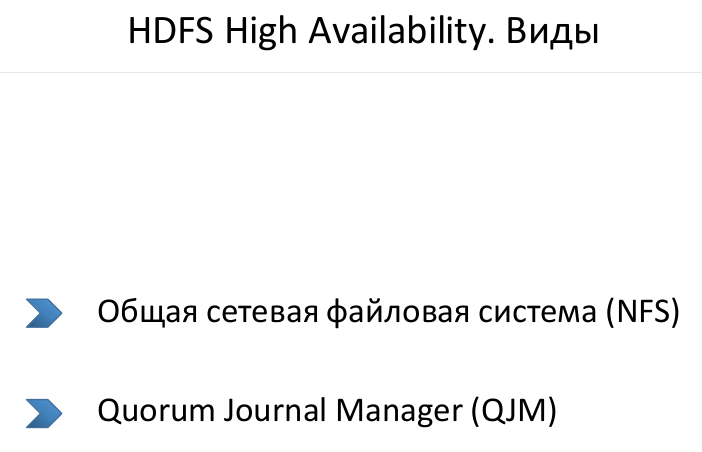
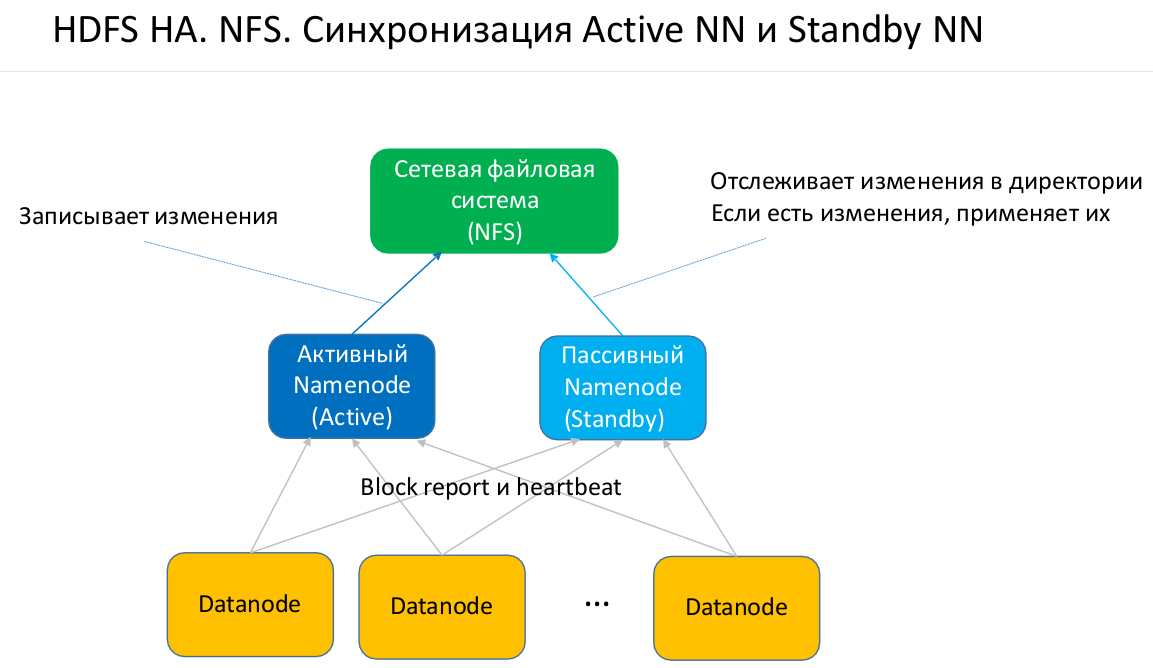
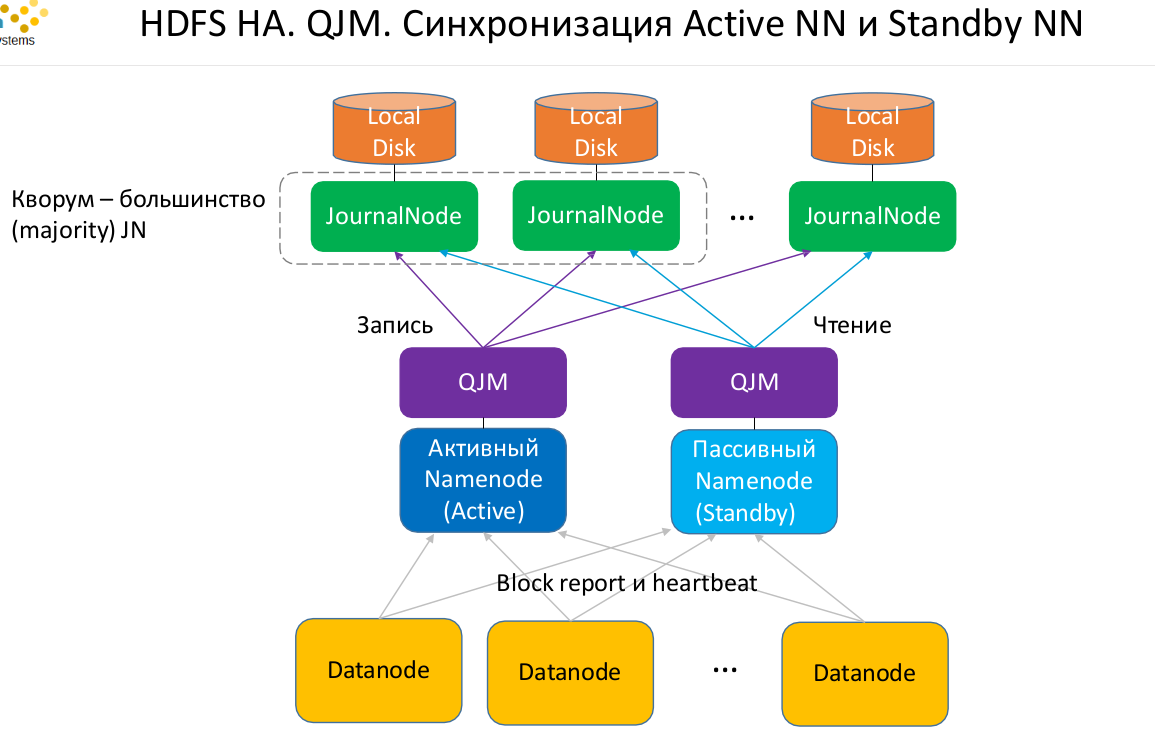
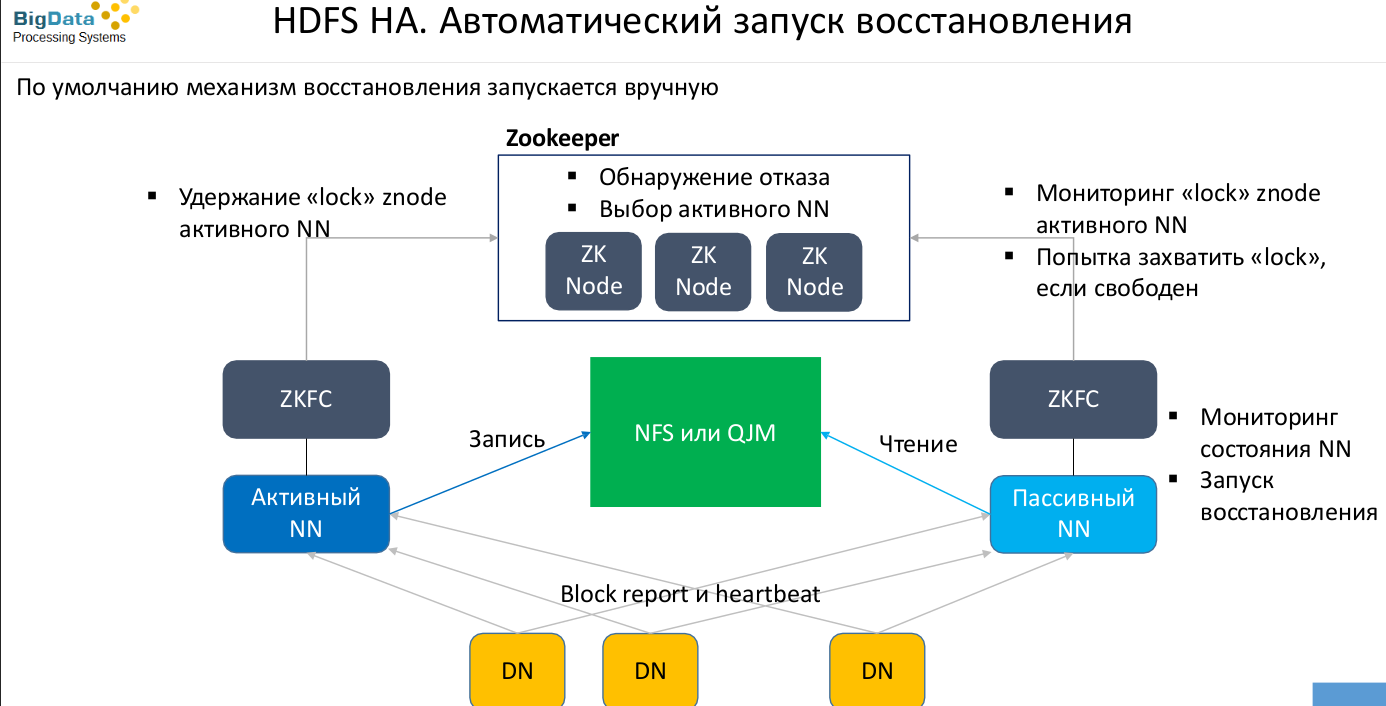
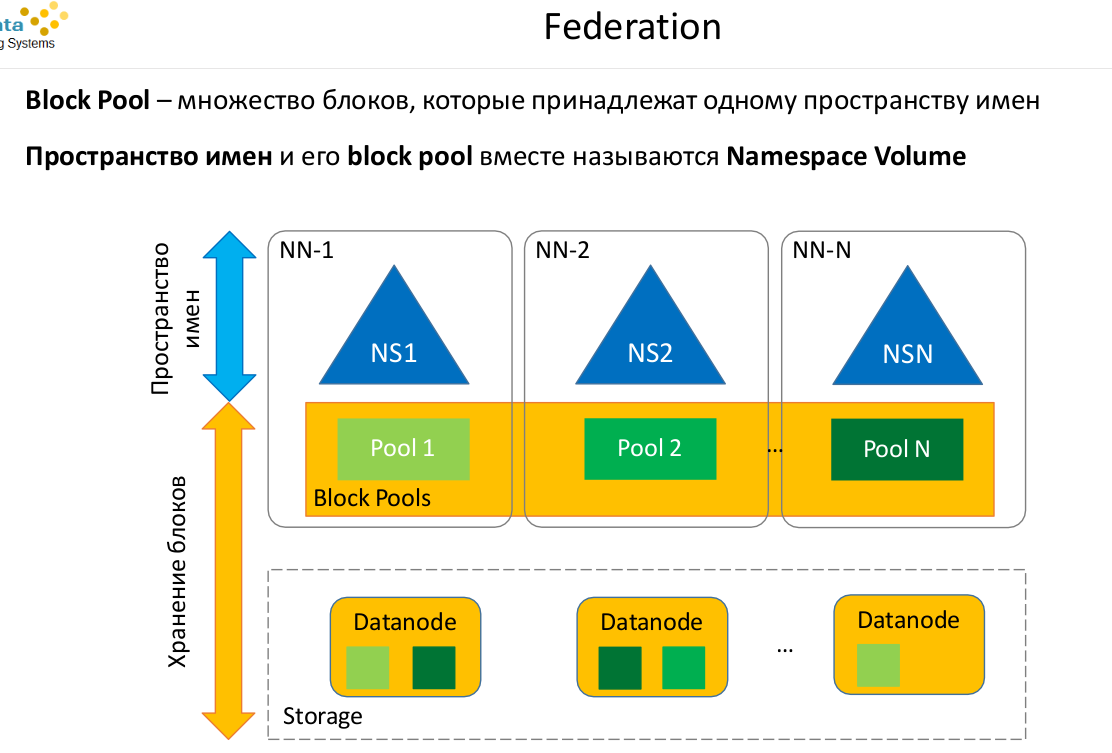
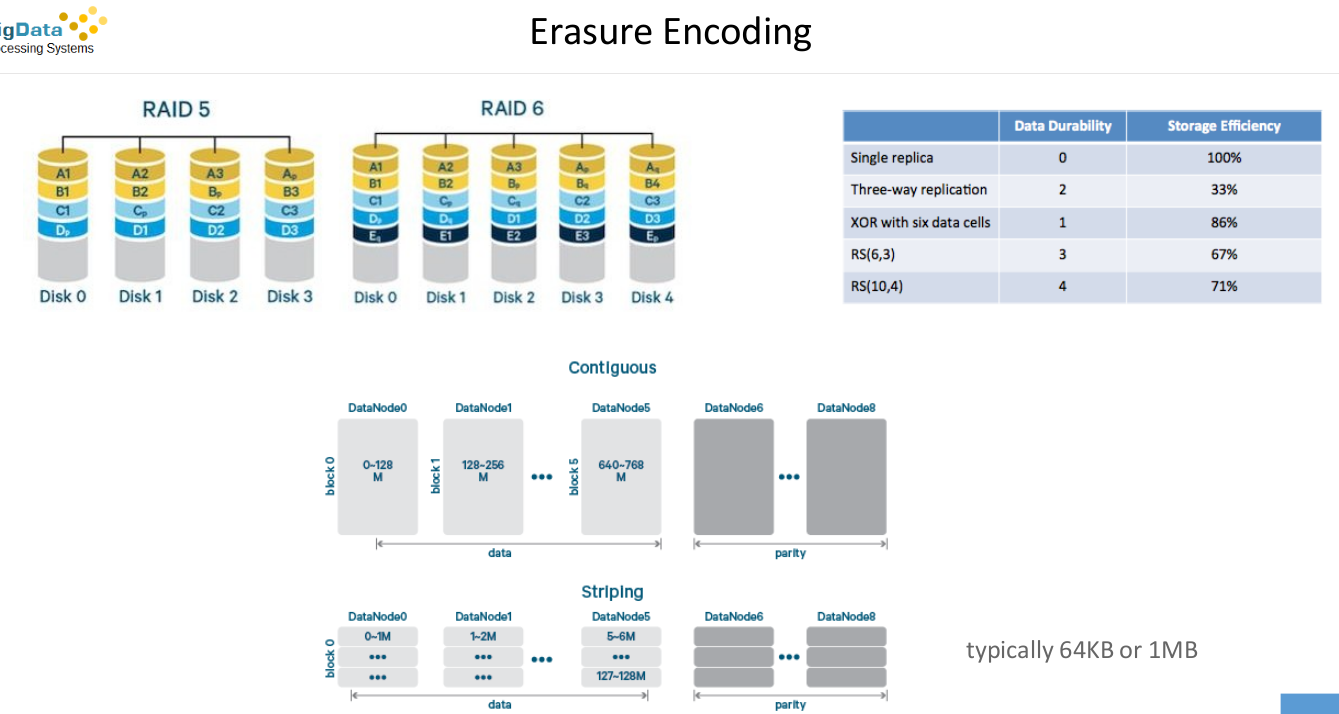

# Про практику:
### Задача - создать проект на JAVA и с помощью него записать код
### Можно попробовать это все на докере развернуть...

- по практике отдельные отчеты
- Практика по HDFS выполняем

Datanode-ы и Namenode-ы работают по SSH
По WEB-у потыкаться...
И потом все ручками попробовать сделать

Смысл:
- Запустить HADOOP развернуть HDFS посмотреть конфигурационные файлы... 
- и запустить на HDFS...

Попробовать все развернуть на DOCKER-е